In [1]:
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

import ajf_plts

SEED = ajf_plts.get_seed("temp_to_freq_model.ipynb")

In [2]:
plt.style.use(["./ajf_plts/base.mplstyle", "./ajf_plts/legend_frame.mplstyle"])

This code does the follow steps:
* Joins together the various MIDAS year files
* Converts the index to be half hourly to match the SSI freqs
* Interpolates the NaNs that are placed at the half hour positions

# Load MIDAS weather data

In [3]:
midas_df = pd.concat(
    [
        pd.read_csv(
            f,
            engine="python",
            skiprows=280,
            skipfooter=1,
            usecols=["ob_time", "air_temperature"],
            parse_dates=["ob_time"],
            infer_datetime_format=True,
            index_col=["ob_time"],
        ).dropna()
        for f in glob.glob("CEDA_Portglenone/midas-*.csv")
    ]
).asfreq("1H")

print(midas_df)
midas_df.describe()

                     air_temperature
ob_time                             
2018-01-01 00:00:00              3.9
2018-01-01 01:00:00              3.8
2018-01-01 02:00:00              4.1
2018-01-01 03:00:00              4.0
2018-01-01 04:00:00              4.3
...                              ...
2021-12-31 19:00:00             12.0
2021-12-31 20:00:00             12.1
2021-12-31 21:00:00             12.2
2021-12-31 22:00:00             11.9
2021-12-31 23:00:00             12.0

[35064 rows x 1 columns]


,air_temperature
count,35035.000000
mean,9.497226
std,5.003864
min,-4.300000
25%,5.800000
50%,9.200000
75%,13.100000
max,29.300000


## Fill in missing values

In [4]:
print(midas_df[midas_df.isna().values])

                     air_temperature
ob_time                             
2018-01-05 13:00:00              NaN
2018-01-05 14:00:00              NaN
2018-01-05 15:00:00              NaN
2018-07-18 11:00:00              NaN
2018-07-18 12:00:00              NaN
2018-07-25 16:00:00              NaN
2018-07-25 17:00:00              NaN
2018-07-25 18:00:00              NaN
2018-07-25 19:00:00              NaN
2019-01-28 13:00:00              NaN
2019-01-28 14:00:00              NaN
2019-07-24 12:00:00              NaN
2019-07-24 13:00:00              NaN
2019-08-02 16:00:00              NaN
2019-11-12 14:00:00              NaN
2019-11-12 15:00:00              NaN
2020-01-16 11:00:00              NaN
2020-01-16 12:00:00              NaN
2021-06-03 12:00:00              NaN
2021-06-03 13:00:00              NaN
2021-06-03 14:00:00              NaN
2021-06-03 15:00:00              NaN
2021-10-12 11:00:00              NaN
2021-11-10 11:00:00              NaN
2021-11-10 12:00:00              NaN
2

In [5]:
midas_df = midas_df.interpolate().reset_index().rename(columns={"ob_time": "time"})
print(midas_df)

                     time  air_temperature
0     2018-01-01 00:00:00              3.9
1     2018-01-01 01:00:00              3.8
2     2018-01-01 02:00:00              4.1
3     2018-01-01 03:00:00              4.0
4     2018-01-01 04:00:00              4.3
...                   ...              ...
35059 2021-12-31 19:00:00             12.0
35060 2021-12-31 20:00:00             12.1
35061 2021-12-31 21:00:00             12.2
35062 2021-12-31 22:00:00             11.9
35063 2021-12-31 23:00:00             12.0

[35064 rows x 2 columns]


# Load in bridge frequency data

In [6]:
import scipy.io

mode_1_mat = scipy.io.loadmat("mode_1.mat")

time1 = pd.to_datetime(mode_1_mat["Time"].reshape(-1), unit="s")
freq1 = mode_1_mat["Frequency"].reshape(-1)
temp1 = mode_1_mat["TempT_0"].reshape(-1)

gh_df = pd.DataFrame({"time": time1, "freq": freq1}).sort_values("time")
print(gh_df)
gh_df.describe()

                     time      freq
0     2018-10-19 06:17:06  5.707690
1     2018-10-19 06:47:06  5.705696
2     2018-10-19 07:17:06  5.713192
3     2018-10-19 07:47:06  5.689763
4     2018-10-19 08:17:06  5.675845
...                   ...       ...
18426 2021-03-30 04:47:20  5.693058
18427 2021-03-30 05:17:20  5.702516
18428 2021-03-30 05:47:21  5.684138
18429 2021-03-30 06:17:21  5.658545
18430 2021-03-30 06:47:21  5.679977

[18431 rows x 2 columns]


,freq
count,18431.000000
mean,5.683987
std,0.130653
min,5.003418
25%,5.594548
50%,5.708642
75%,5.766512
max,6.492711


In [56]:
df = pd.merge_asof(
    left=midas_df,
    right=gh_df,
    on="time",
    tolerance=pd.Timedelta("1H"),
    direction="nearest",
).set_index("time")

# remove nans at top and tail of dataset
df = df.loc[df.dropna().index.min() <= df.index]
df = df.loc[df.index <= df.dropna().index.max()]

full_df = df.copy()
print(df)

                     air_temperature      freq
time                                          
2018-10-19 06:00:00              8.2  5.707690
2018-10-19 07:00:00              8.4  5.705696
2018-10-19 08:00:00              8.6  5.689763
2018-10-19 09:00:00              8.8  5.680789
2018-10-19 10:00:00              9.7  5.705422
...                              ...       ...
2021-03-30 03:00:00             11.7  5.720516
2021-03-30 04:00:00             12.2  5.720516
2021-03-30 05:00:00             12.4  5.693058
2021-03-30 06:00:00             11.9  5.684138
2021-03-30 07:00:00             11.6  5.679977

[21434 rows x 2 columns]


In [57]:
axvspan_paras = dict(ec="none", fc="grey", zorder=-100)

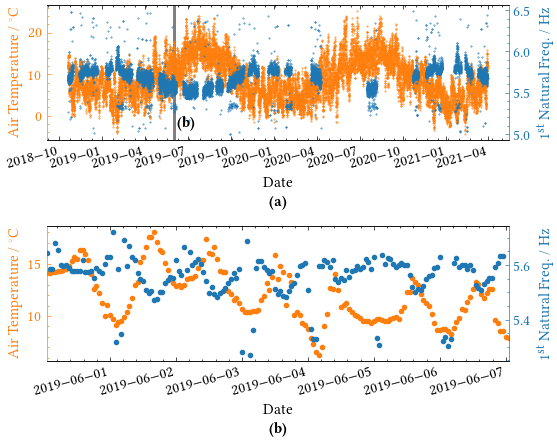

In [58]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, 2.0 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=2)

freq_vals = df.freq.dropna()

axes2 = [ax.twinx() for ax in axes]

axes[0].plot(df.air_temperature, ls="", c="C1", marker=".", markersize=0.75, rasterized=True)
axes2[0].plot(df.freq, ls="", c="C0", marker=".", markersize=0.75, rasterized=True)

start_date = pd.to_datetime("2019-5-31 01:00:00")
end_date = pd.to_datetime("2019-6-7 01:00:00")

mask = (df.index >= start_date) & (df.index <= end_date)
axes[1].plot(df.air_temperature[mask], ls="", c="C1", marker=".", rasterized=True)
axes2[1].plot(df.freq[mask], ls="", c="C0", marker=".", rasterized=True)
axes[1].set_xlim((start_date, end_date))

axes[0].axvspan(start_date, end_date, **axvspan_paras)

axes2[0].annotate(
    r"\bfseries (b)",
    xy=(start_date+pd.to_timedelta('200H'), 5.2),
    ha="left",
    va="top",
    fontsize=11.0,
)

for ax in axes:
    ax.set_xlabel("Date")

for ax in axes:
    ax.set_ylabel(r"Air Temperature / \unit{\celsius}", c="C1")
    ax.tick_params(axis="y", which="both", colors="C1")
    ax.spines["left"].set_color("C1")
    ax.spines["right"].set_visible(False)
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right")

for ax in axes2:
    ax.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}", c="C0")
    ax.tick_params(axis="y", which="both", colors="C0")
    ax.spines["right"].set_color("C0")
    ax.spines["left"].set_visible(False)

ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, "figRawFirstFrequenciesTemps.pdf")

## Find outliers

In [59]:
def median_absolute_deviation(x):
    """
    Returns the median absolute deviation from the window's median
    :param x: Values in the window
    :return: MAD
    """
    return np.median(np.abs(x - np.median(x)))


def hampel(ts, window_size=5, n=3, imputation=False):

    """
    Median absolute deviation (MAD) outlier in Time Series
    :param ts: a pandas Series object representing the timeseries
    :param window_size: total window size will be computed as 2*window_size + 1
    :param n: threshold, default is 3 (Pearson's rule)
    :param imputation: If set to False, then the algorithm will be used for outlier detection.
        If set to True, then the algorithm will also imput the outliers with the rolling median.
    :return: Returns the outlier indices if imputation=False and the corrected timeseries if imputation=True
    """

    if type(ts) != pd.Series:
        raise ValueError("Timeserie object must be of tyme pandas.Series.")

    #    if type(window_size) == int:
    #        raise ValueError("Window size must be of type integer.")
    #    else:
    #        if window_size <= 0:
    #            raise ValueError("Window size must be more than 0.")
    #
    #     if type(n) != int:
    #         raise ValueError("Window size must be of type integer.")
    #     else:
    #         if n < 0:
    #             raise ValueError("Window size must be equal or more than 0.")

    # Copy the Series object. This will be the cleaned timeserie
    ts_cleaned = ts.copy()

    # Constant scale factor, which depends on the distribution
    # In this case, we assume normal distribution
    rolling_ts = ts_cleaned.rolling(window_size, min_periods=1, center=True)
    rolling_median = rolling_ts.median().fillna(method="bfill").fillna(method="ffill")
    rolling_mad = (
        rolling_ts.apply(median_absolute_deviation)
        .fillna(method="bfill")
        .fillna(method="ffill")
    )

    outlier_indices = list(
        np.array(
            np.where(np.abs(ts_cleaned - rolling_median) >= (n * rolling_mad))
        ).flatten()
    )

    if imputation:
        ts_cleaned[outlier_indices] = rolling_median[outlier_indices]
        return ts_cleaned

    return outlier_indices


outliers = hampel(ts=df.freq, window_size=int(24), n=3.5)
df.freq.iloc[outliers] = np.nan

outlier_df = df.copy()
outlier_df.freq = np.nan
outlier_df.iloc[outliers] = full_df.iloc[outliers]

## Check outliers are at night

Total outliers: N=839 (3.91%)

Day outliers:   N=90 (10.73%)
Night outliers: N=749 (89.27%)


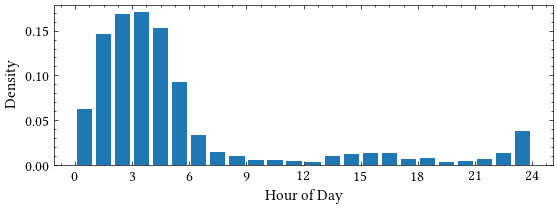

In [60]:
outlier_hours = df.index[outliers].hour

day_hours = np.arange(7, 19)

day_outliers = outlier_hours.isin(day_hours).sum()
night_outliers = (~(outlier_hours.isin(day_hours))).sum()

print(f"Total outliers: N={len(outliers)} ({len(outliers)/len(df):2.2%})")
print()
print(
    f"Day outliers:   N={day_outliers} ({day_outliers/(day_outliers+night_outliers):2.2%})"
)
print(
    f"Night outliers: N={night_outliers} ({night_outliers/(day_outliers+night_outliers):2.2%})"
)

%matplotlib widget
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)
outlier_hours.to_series().plot(
    kind="hist", density=True, rwidth=0.8, bins=np.arange(25)
)
ax.set_xlabel("Hour of Day")
ax.set_xticks(np.arange(25)[::3])
ax.set_ylabel("Density")
fig.tight_layout()
ajf_plts.save_fig(fig, "figOutlierTimes.pdf")

## Plot

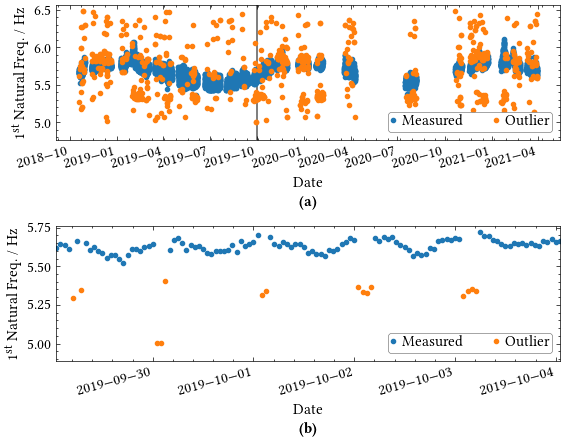

In [61]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, 2.0 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=2)
axes = axes.ravel()

obs_props = dict(
    ls="", marker=".", markersize=6.0, c="C0", label="Measured", rasterized=True
)
out_props = dict(
    ls="",
    #marker="o",
    #markersize=6.0,
    marker=".",
    c="C1",
    #markerfacecolor="none",
    label="Outlier",
    rasterized=True,
)

# OVERALL PLOT
axes[0].plot(df.freq, **obs_props)
axes[0].plot(full_df.freq[outliers], **out_props)
axes[0].set_ylim(axes[0].get_ylim() + [-0.1, 0.0] * np.diff(axes[0].get_ylim()))

# ZOOM IN
start = pd.Timestamp("2019-09-29 01:00:00")
end = start + pd.Timedelta("5d")
mask = (start <= full_df.index) * (full_df.index <= end)

axes[1].plot(df.freq[mask], **obs_props)
axes[1].plot(outlier_df.freq[mask], **out_props)
axes[1].set_ylim(axes[1].get_ylim() + [-0.1, 0.0] * np.diff(axes[1].get_ylim()))

axes[1].set_xlim((start, end))
axes[0].axvspan(start, end, **axvspan_paras)

for ax in axes:
    ax.set_xlabel("Date")
    ax.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}")
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right")
    legend = ax.legend(
        loc='lower right', ncol=3, borderpad=0.2, handlelength=0.25, handletextpad=0.5
    )

ajf_plts.caption_axes(axes)
fig.tight_layout()

ajf_plts.save_fig(fig, "figFreqOutlierInterp.pdf")

# train validate test split

In [97]:
all_df = df.dropna().copy()

n_points = len(all_df)
train_prop = 0.55
valid_prop = 0.15

train_split_ind = all_df.index.values[int(n_points * train_prop)]
valid_split_ind = all_df.index.values[int(n_points * (train_prop+valid_prop))]

min_ind = all_df.index.min()
max_ind = all_df.index.max()

train_df = df.loc[
    (min_ind <= df.index) * (df.index < train_split_ind)
].copy()
valid_df = df.loc[
    (train_split_ind <= df.index) * (df.index < valid_split_ind)
].copy()
test_df = df.loc[
    (valid_split_ind <= df.index) * (df.index <= max_ind)
].copy()

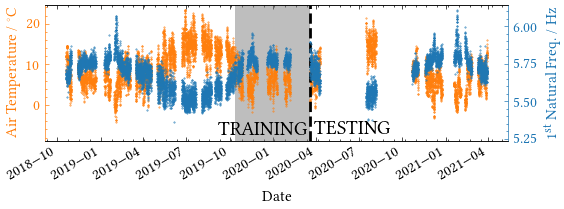

In [99]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize, ncols=1, nrows=1)

freq_vals = df.freq.dropna()

# has to come before twinx
ax.axvspan(train_split_ind, valid_split_ind, facecolor='C7', alpha=0.5)

ax2 = ax.twinx()

all_df.air_temperature.plot(
    ax=ax, ls="", c="C1", marker=".", markersize=0.75, zorder=100
).set_rasterized(True)

all_df.freq.plot(ax=ax2, ls="", c="C0", marker=".", markersize=0.75, zorder=100).set_rasterized(True)

ax.set_xlabel("Date")

ax.set_ylabel(r"Air Temperature / \unit{\celsius}", c="C1")
ax.tick_params(axis="y", which="both", colors="C1")
ax.spines["left"].set_color("C1")
ax.spines["right"].set_visible(False)

ax2.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}", c="C0")
ax2.tick_params(axis="y", which="both", colors="C0")
ax2.spines["right"].set_color("C0")
ax2.spines["left"].set_visible(False)


for ax in [ax, ax2]:
    ax.set_ylim(ax.get_ylim() + [-0.11, 0.0] * np.diff(ax.get_ylim()))

#ajf_plts.annotate_train_test_split(ax2, train_split_ind, pd.Timedelta("200H"))
ajf_plts.annotate_train_test_split(ax2, valid_split_ind, pd.Timedelta("200H"))

fig.tight_layout()
ajf_plts.save_fig(fig, "figTrainTestSplit.pdf")

## fitting ARDL model

In [100]:
import statsmodels.api as sm
import warnings

warnings.simplefilter("ignore", sm.tools.sm_exceptions.InterpolationWarning)

# check for stationarity
alpha = 0.05
x = train_df.dropna().air_temperature.values
x = x.reshape(-1, 1)
y = train_df.dropna().freq.values

adf_res = sm.tsa.stattools.adfuller(x)
kpss_res = sm.tsa.stattools.kpss(x)
print(f"x")
print(f"ADF says {'non-stationary' if adf_res[1] > alpha else 'stationary'}")
print(f"KPSS says {'non-stationary' if kpss_res[1] < alpha else 'stationary'}")
print("")

adf_res = sm.tsa.stattools.adfuller(np.diff(x, axis=0))
kpss_res = sm.tsa.stattools.kpss(np.diff(x, axis=0))
print(f"1st order difference of x")
print(f"ADF says {'non-stationary' if adf_res[1] > alpha else 'stationary'}")
print(f"KPSS says {'non-stationary' if kpss_res[1] < alpha else 'stationary'}")
print("")

adf_res = sm.tsa.stattools.adfuller(y)
kpss_res = sm.tsa.stattools.kpss(y)
print(f"y")
print(f"ADF says {'non-stationary' if adf_res[1] > alpha else 'stationary'}")
print(f"KPSS says {'non-stationary' if kpss_res[1] < alpha else 'stationary'}")
print("")

adf_res = sm.tsa.stattools.adfuller(np.diff(y, axis=0))
kpss_res = sm.tsa.stattools.kpss(np.diff(y, axis=0))
print(f"1st order difference of y")
print(f"ADF says {'non-stationary' if adf_res[1] > alpha else 'stationary'}")
print(f"KPSS says {'non-stationary' if kpss_res[1] < alpha else 'stationary'}")
print("")

x
ADF says stationary
KPSS says non-stationary

1st order difference of x
ADF says stationary
KPSS says stationary

y
ADF says non-stationary
KPSS says non-stationary

1st order difference of y
ADF says stationary
KPSS says stationary



In [101]:
# test for cointegration

for tr in ['n', 'c', 'ct', 'ctt']:
    for ic in ['AIC', 'BIC']:
        eg_test = sm.tsa.coint(y, x, maxlag=24, autolag=ic, trend=tr)
        print(
            f"Engle-Granger two-step cointegration test with {tr} using {ic} says {'cointegrated' if eg_test[1] < alpha else 'not cointegrated'}"
        )

Engle-Granger two-step cointegration test with n using AIC says cointegrated
Engle-Granger two-step cointegration test with n using BIC says cointegrated
Engle-Granger two-step cointegration test with c using AIC says cointegrated
Engle-Granger two-step cointegration test with c using BIC says cointegrated
Engle-Granger two-step cointegration test with ct using AIC says cointegrated
Engle-Granger two-step cointegration test with ct using BIC says cointegrated
Engle-Granger two-step cointegration test with ctt using AIC says cointegrated
Engle-Granger two-step cointegration test with ctt using BIC says cointegrated


In [102]:
x_train = train_df.dropna().air_temperature.values.reshape(-1, 1)
y_train = train_df.dropna().freq.values

x_valid = valid_df.dropna().air_temperature.values.reshape(-1, 1)
y_valid = valid_df.dropna().freq.values

x_test = test_df.dropna().air_temperature.values.reshape(-1, 1)
y_test = test_df.dropna().freq.values

In [103]:
max_ar_lag = 6
max_ex_lag = 6
causal = False 
trend = 'c'

best_train_rmse = (100.0, 100.0)
best_train_lag_order = ''

best_valid_rmse = (100.0, 100.0)
best_valid_lag_order = ''

for lag in np.arange(0, max_ar_lag+1):
    for order in np.arange(int(causal), max_ex_lag+1):
        model = sm.tsa.ARDL(endog=y_train,
                            lags=lag,
                            exog=x_train,
                            order=order,
                            causal=causal,
                            trend=trend,
                            missing='drop')
        res = model.fit()

        _train_preds = res.predict(start=len(x_train), end=len(x_train)+len(x_train)-1,exog_oos=x_train)
        _valid_preds = res.predict(start=len(x_train), end=len(x_train)+len(x_valid)-1,exog_oos=x_valid)

        train_preds = pd.Series(index=train_df.dropna().index,
                                      data=_train_preds)
        valid_preds = pd.Series(index=valid_df.dropna().index,
                                      data=_valid_preds)

        train_res = y_train - train_preds
        valid_res = y_valid - valid_preds
        
        train_rmse = np.sqrt(np.mean(train_res**2))
        valid_rmse = np.sqrt(np.mean(valid_res**2))
        
        if train_rmse < best_train_rmse[0]:
            best_train_rmse = (train_rmse, valid_rmse)
            best_train_lag_order = f'Lag: {lag} Order: {order}'
            
        if valid_rmse < best_valid_rmse[1]:
            best_valid_rmse = (train_rmse, valid_rmse)
            best_valid_lag_order = f'Lag: {lag} Order: {order}'

        #print(f'Lag: {lag} Order: {order}')
        #print(f'Train RMSE: {np.sqrt(np.mean(train_res**2)):2.3e}')
        #print(f'Valid RMSE: {np.sqrt(np.mean(valid_res**2)):2.3e}')
        #print()
        
print(f'Train RMSE selected {best_train_lag_order}')
print(f'Train RMSE: {best_train_rmse[0]:2.2e}')
print(f'Valid RMSE: {best_train_rmse[1]:2.2e}')
print()
print(f'Valid RMSE selected {best_valid_lag_order}')
print(f'Train RMSE: {best_valid_rmse[0]:2.2e}')
print(f'Valid RMSE: {best_valid_rmse[1]:2.2e}')

Train RMSE selected Lag: 5 Order: 4
Train RMSE: 5.16e-02
Valid RMSE: 4.94e-02

Valid RMSE selected Lag: 4 Order: 2
Train RMSE: 5.33e-02
Valid RMSE: 4.79e-02


In [104]:
model = sm.tsa.ARDL(endog=y_train,
                    lags=4,
                    exog=x_train,
                    order=2,
                    causal=causal,
                    trend=trend,
                    missing='drop')
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 5302
Model:                     ARDL(4, 2)   Log Likelihood               11520.832
Method:               Conditional MLE   S.D. of innovations              0.028
Date:                Sat, 17 Sep 2022   AIC                         -23023.665
Time:                        13:43:27   BIC                         -22964.489
Sample:                             4   HQIC                        -23002.985
                                 5302                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6930      0.041     16.900      0.000       0.613       0.773
y.L1           0.5505      0.014     40.432      0.000       0.524       0.577
y.L2           0.2323      0.016     14.943      0.000       0.202       0.263
y.L3           0.0910      0.015      5.876      0.000       0.061       0.121
y.L4           0.0086      0.013      0.673      0.501      -0.016       0.034
x0.L0         -0.0073      0.000    -15.942      0.000      -0.008      -0.006
x0.L1         -0.0017      0.001     -2.306      0.021      -0.003      -0.000
x0.L2          0.0062      0.000     12.636      0.000       0.005       0.007
==============================================================================
"""

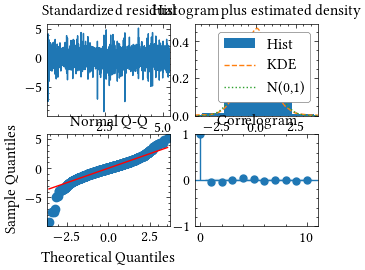

In [105]:
_ = res.plot_diagnostics()

In [106]:
trainvalid_df = pd.concat([train_df, valid_df])

In [107]:
x_train = trainvalid_df.air_temperature.values
x_test = test_df.air_temperature.values

y_train = trainvalid_df.dropna().freq.values

orig_exog_len = len(res.model.exog)

_train_preds = res.predict(start=orig_exog_len, end=orig_exog_len+len(x_train)-1,exog_oos=x_train)
_test_preds = res.predict(start=orig_exog_len, end=orig_exog_len+len(x_test)-1,exog_oos=x_test)

In [108]:
train_preds = pd.Series(index=trainvalid_df.index,
                              data=_train_preds)
test_preds = pd.Series(index=test_df.index,
                              data=_test_preds)

In [109]:
y_test.shape, test_preds.shape

((2893,), (9008,))

In [110]:
train_res = y_train - train_preds.loc[trainvalid_df.dropna().index]
test_res = y_test - test_preds.loc[test_df.dropna().index]

In [111]:
from sklearn.metrics import mean_squared_error

print(
    "Train RMSE: %.3f Hz"
    % (np.sqrt(mean_squared_error(y_train,train_preds.loc[trainvalid_df.dropna().index])))
)
print(
    "Test RMSE: %.3f Hz"
    % (np.sqrt(mean_squared_error(y_test,test_preds.loc[test_df.dropna().index])))
)

Train RMSE: 0.053 Hz
Test RMSE: 0.050 Hz


In [112]:
sm.stats.durbin_watson(train_res), sm.stats.durbin_watson(test_res)

(0.3163525409345413, 0.4601571837609402)

In [113]:
actual_col = "C0"
predict_col = "C6"
train_col = "C3"
valid_col = 'C8'
test_col = "C4"

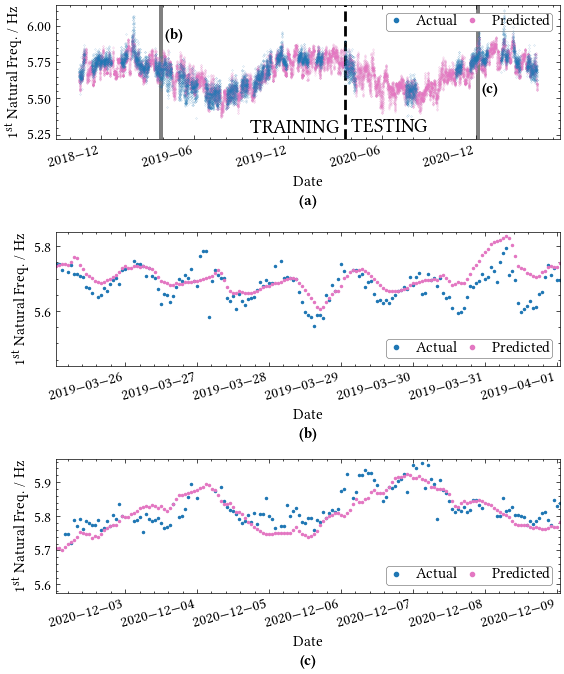

In [114]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, 3.0*ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=3)

axes = axes.ravel()

props = dict(ls="", marker=".", markersize=0.25, alpha=0.75, rasterized=True)

# OVERALL PLOT
axes[0].plot(trainvalid_df.index, trainvalid_df.freq, **props, c=actual_col, zorder=10, label="Actual")
axes[0].plot(test_df.index, test_df.freq, **props, c=actual_col, zorder=10, label="_Actual")

axes[0].plot(
    train_preds.index, train_preds, **props, c=predict_col, label="Predicted"
)
axes[0].plot(
    test_preds.index, test_preds, **props, c=predict_col, label="_Predicted"
)

axes[0].xaxis.set_major_locator(mpl.dates.MonthLocator(interval=6))
axes[0].xaxis.set_minor_locator(mpl.dates.MonthLocator())


# TRAIN PLOT
train_start = pd.to_datetime("2019-3-25 01:00:00")
train_end = train_start + pd.Timedelta("7d")
train_mask = (train_start <= trainvalid_df.index) * (
    trainvalid_df.index <= train_end
)

props["markersize"] = 3.0
props["alpha"] = 1.0

axes[1].plot(
    trainvalid_df.freq.loc[train_mask], **props, c=actual_col, label="Actual"
)
axes[1].plot(
    train_preds[train_mask],
    **props,
    c=predict_col,
    label="Predicted",
)

axes[1].set_xlim((train_start, train_end))

# TEST PLOT
test_start = pd.to_datetime("2020-12-2 01:00:00")
test_end = test_start + pd.Timedelta("7d")
test_mask = (test_start <= test_df.index) * (
    test_df.index <= test_end
)

axes[2].plot(
    test_df.freq.loc[test_mask],
    **props,
    c=actual_col,
    label="Actual",
)
axes[2].plot(
    test_df.index[test_mask],
    test_preds[test_mask],
    **props,
    c=predict_col,
    label="Predicted",
)

axes[2].set_xlim((test_start, test_end))

for i, ax in enumerate(axes):
    ax.set_xlabel("Date")
    ax.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}")
    ax.set_ylim(ax.get_ylim() * np.array([0.98, 1.0]))
    legend = ax.legend(
        loc="upper right" if i < 1 else 'lower right', ncol=2, borderpad=0.15, handlelength=1.0, columnspacing=0.5
    )
    for lh in legend.legendHandles:
        lh.set_markersize(6)
        lh.set_alpha(1.0)
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right")

for ax in axes[1:]:
    ax.xaxis.set_major_locator(mpl.dates.DayLocator())
    ax.xaxis.set_major_formatter(mpl.dates.AutoDateFormatter(mpl.dates.DateLocator()))

ajf_plts.annotate_train_test_split(
    ax=axes[0], split_x_val=valid_split_ind, label_x_offset=pd.Timedelta("300H")
)

axes[0].axvspan(train_start, train_end, **axvspan_paras)
axes[0].annotate(
    r"\bfseries (b)",
    xy=(
        train_end + pd.Timedelta("100H"),
        axes[0]
        .transData.inverted()
        .transform((0.0, axes[0].transAxes.transform((0.0, 0.82))[1]))[1],
    ),
    ha="left",
    va="top",
    fontsize=11.0,
)

axes[0].axvspan(test_start, test_end, **axvspan_paras)
axes[0].annotate(
    r"\bfseries (c)",
    xy=(
        test_end + pd.Timedelta("100H"),
        axes[0]
        .transData.inverted()
        .transform((0.0, axes[0].transAxes.transform((0.0, 0.42))[1]))[1],
    ),
    ha="left",
    va="top",
    fontsize=11.0,
)

ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, 'figARDLActualPredicted.pdf')

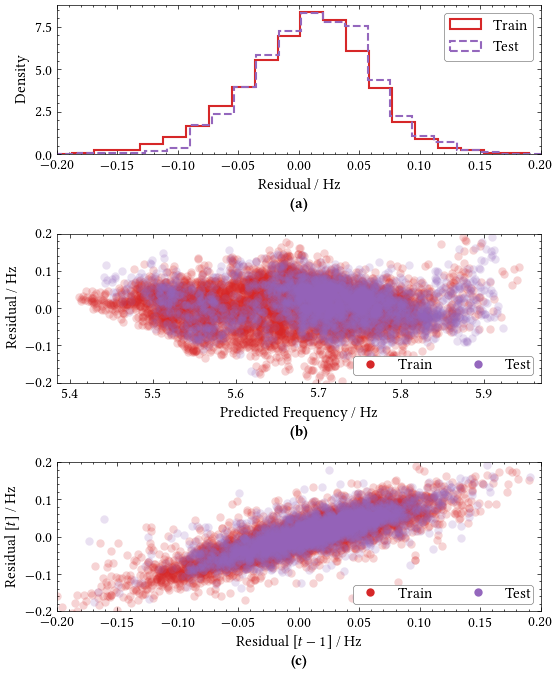

In [115]:
%matplotlib widget
figsize = (ajf_plts.text_width_inches, 3.0 * ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=3)

ax_props = dict(bins=25, density=True, histtype="step", lw=1.5)

axes[0].hist(train_res, **ax_props, ec=train_col, label="Train")
#axes[0].hist(valid_res, **ax_props, ec=valid_col, label="Valid")
axes[0].hist(test_res, **ax_props, ec=test_col, label="Test")
axes[0].set_xlabel(r"Air Temperature / \unit{\celsius}")
axes[0].set_xlabel(r"Residual / \unit{\hertz}")
axes[0].set_ylabel("Density")
legend = axes[0].legend(loc="upper right")
axes[0].set_xlim((-0.2, 0.2))

ax_props = dict(ls="", marker="o", markeredgecolor='none', alpha=0.2, rasterized=True)

axes[1].plot(train_preds.loc[train_res.index], train_res, **ax_props, c=train_col, label="Train")
#axes[1].plot(valid_preds.loc[valid_res.index], valid_res, **ax_props, c=valid_col, label="Valid")
axes[1].plot(test_preds.loc[test_res.index], test_res, **ax_props, c=test_col, label="Test")
axes[1].set_xlabel("Predicted Frequency / Hz")
axes[1].set_ylabel("Residual / Hz")

axes[2].plot(train_res[:-1], train_res[1:], **ax_props, c=train_col, label='Train')
#axes[2].plot(valid_res[:-1], valid_res[1:], **ax_props, c=valid_col, label='Valid')
axes[2].plot(test_res[:-1], test_res[1:], **ax_props, c=test_col, label='Test')
axes[2].set_xlabel(r"Air Temperature / \unit{\celsius}")
axes[2].set_xlabel(r"Residual$\;\left[{t-1}\right]$ / \unit{\hertz}")
axes[2].set_ylabel(r"Residual$\;\left[{t}\right]$ / \unit{\hertz}")

for ax in axes[1:]:
    legend = ax.legend(loc="lower right", ncol=3, borderpad=0.15)
    for lh in legend.legendHandles:
        lh.set_markersize(6)
        lh.set_alpha(1.0)
    ax.set_ylim((-0.2, 0.2))
axes[-1].set_xlim((-0.2, 0.2))

ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, 'figARDLResiduals.pdf')

In [116]:
res.save('ardl_model.pkl')

# modal test day

In [117]:
import pickle

In [118]:
with open('./ardl_model.pkl', 'rb') as f:
    ardl_model = pickle.load(f)

In [119]:
df = midas_df.set_index('time')
df['freq'] = ardl_model.predict(start=len(ardl_model.data.exog), end=len(ardl_model.data.exog)+len(midas_df)-1,exog_oos=df.air_temperature)

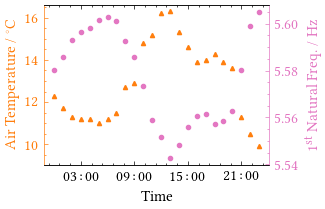

In [120]:
%matplotlib widget
figsize = (0.6*ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

start = pd.to_datetime('2018-6-18 00:00:00')
end = pd.to_datetime('2018-6-18 23:59:59')
mask = (start <= df.index) * (df.index <= end)

ax.plot(df[mask].air_temperature, ls='', marker='^', markersize=3.0, markerfacecolor='C1', markeredgecolor='C1',)

ax2 = ax.twinx()

ax2.plot(df[mask].freq, c=predict_col, ls='', marker='o', markersize=3.0)

ax.xaxis.set_major_locator(mpl.dates.HourLocator(interval=6))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))

ax.set_ylim(ax.get_ylim() + [-0.08, 0.0] * np.diff(ax.get_ylim()))
    
ax.set_xlabel('Time')
ax.set_ylabel(r"Air Temperature / \unit{\celsius}", c="C1")
ax.tick_params(axis="y", which="both", colors="C1")
ax.spines["left"].set_color("C1")
ax.spines["right"].set_visible(False)

ax2.set_ylabel(r"1\textsuperscript{st} Natural Freq. / \unit{\hertz}", c=predict_col)
ax2.tick_params(axis="y", which="both", colors=predict_col)
ax2.spines["right"].set_color(predict_col)
ax2.spines["left"].set_visible(False)


fig.tight_layout()
ajf_plts.save_fig(fig, 'figModalTestFreqPred.pdf')